# Query #

---
## Part 1: 
### Word Frequency Statistics: Google Patents Data
    In this section I'll do a general descriptive analysis of my dataset of AI Google Patents. This description will give more insights about the words and check wheteher I need to include other terms to the original query.
---

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.probability import FreqDist
import numpy as np
import glob

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
patentsData = pd.read_pickle("patents_ai_20230223.pkl")

In [17]:
def extract_text(titles):
    try:
        for title in titles:
            if title['language']=='en':
                return title['text']
    except:
        return float('NaN')

In [42]:
#Get text from title and abstract
patentsData['title'] = patentsData.title_localized.apply(extract_text).copy()
patentsData['abstract'] = patentsData.abstract_localized.apply(extract_text).copy()
patentsData.drop(['title_localized', 'abstract_localized'], axis = 1, inplace = True)

In [146]:
len(patentsData)

26218

In [43]:
stop_words = set(stopwords.words('english'))
stop_words.add("None")

def preprocessing(text):
    if isinstance(text, str) and text.lower() != "none":
        words = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
        filtered_words = [word for word in words if word not in stop_words and not any(char.isdigit() for char in word) and word not in string.punctuation]  # Remove stopwords, numbers, and punctuation
        return filtered_words
    return [] 

In [44]:
patentsData['title'] = patentsData['title'].apply(preprocessing)
patentsData['abstract'] = patentsData['abstract'].apply(preprocessing)

In [20]:
#patentsData

In [45]:
from collections import Counter

title_words = [word for words in patentsData['title'] for word in words]
abstract_words = [word for words in patentsData['abstract'] for word in words]

title_word_freq = Counter(title_words)
abstract_word_freq = Counter(abstract_words)

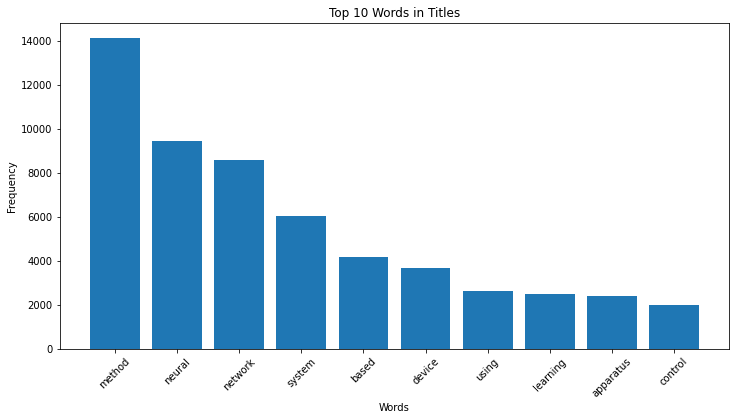

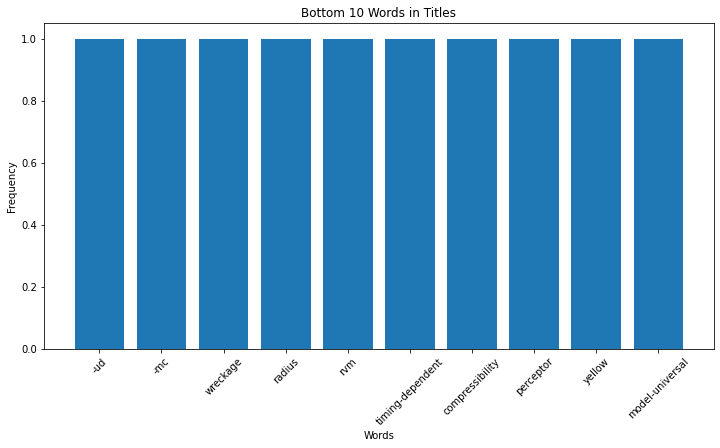

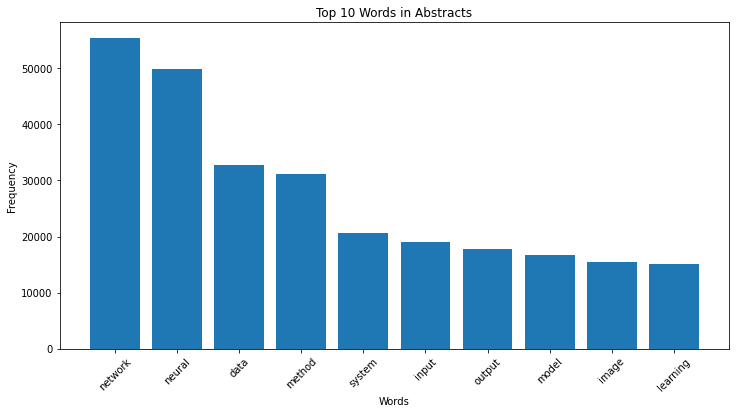

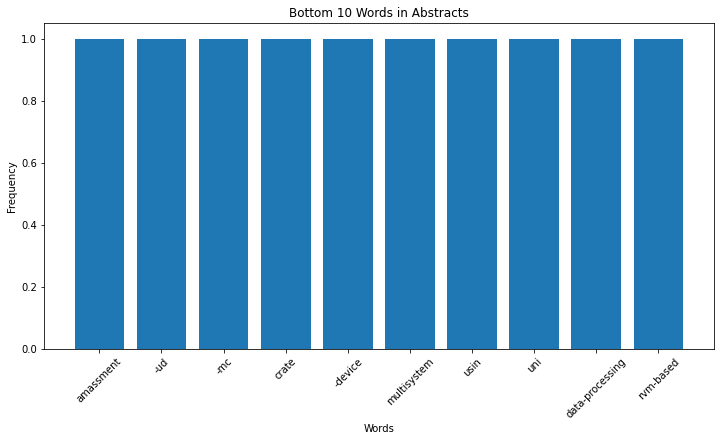

In [48]:
import matplotlib.pyplot as plt

# Plot the most common words in titles
title_common_words = title_word_freq.most_common(10)
title_word, title_count = zip(*title_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(title_word, title_count)
plt.title("Top 10 Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

title_less_common_words = title_word_freq.most_common()[:-11:-1]
title_less_word, title_less_count = zip(*title_less_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(title_less_word, title_less_count)
plt.title("Bottom 10 Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Plot the most common words in abstracts
abstract_common_words = abstract_word_freq.most_common(10)
abstract_word, abstract_count = zip(*abstract_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(abstract_word, abstract_count)
plt.title("Top 10 Words in Abstracts")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Plot the most common words in abstracts
abstract_less_common_words = abstract_word_freq.most_common()[:-11:-1]
abstract_less_word, abstract_less_count = zip(*abstract_less_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(abstract_less_word, abstract_less_count)
plt.title("Bottom 10 Words in Abstracts")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

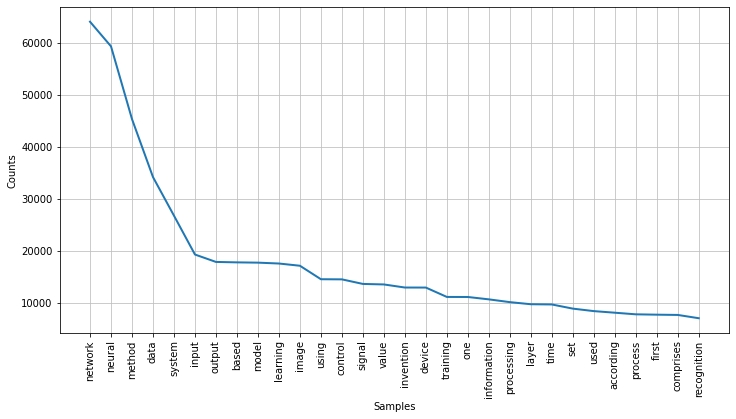

In [47]:
# Combine title and abstract tokens into one list
all_tokens = title_words + abstract_words

# Create a frequency distribution of words
freq_dist = FreqDist(all_tokens)

plt.figure(figsize=(12, 6))

# Plot the word frequency distribution
freq_dist.plot(30, cumulative=False) #displaying 30 words

# If you want to access the frequency counts and the most common words:
common_words = freq_dist.most_common(10)
print(common_words)
print(len(all_tokens))

*From this output I would include "image recognition"**

In [38]:
# Get word frequencies as an array
word_frequencies = np.array(list(freq_dist.values()))

# Calculate summary statistics
mean_frequency = np.mean(word_frequencies)
std_deviation = np.std(word_frequencies)

# Define a threshold for identifying outliers (e.g., words more than 2 standard deviations away)
outlier_threshold = mean_frequency + 2 * std_deviation

# Identify words that are outliers
outliers = {word: freq for word, freq in freq_dist.items() if freq > outlier_threshold}

# Create a DataFrame for the outliers
outliers_df = pd.DataFrame(list(outliers.items()), columns=['Word', 'Frequency'])

# Find the word with the maximum frequency among outliers
max_freq_word = outliers_df.loc[outliers_df['Frequency'].idxmax()]

# Find the word with the minimum frequency among outliers
min_freq_word = outliers_df.loc[outliers_df['Frequency'].idxmin()]

# Display the DataFrame and the words with max and min frequencies
print(outliers_df)
print("Word with Maximum Frequency:", max_freq_word)
print("Word with Minimum Frequency:", min_freq_word)

           Word  Frequency
0    parameters       6558
1        method      45289
2         level       2028
3          load       2020
4     diagnosis       1844
..          ...        ...
287   disclosed       1917
288     present       3003
289      solved       2135
290        thus       1744
291         jpo       2639

[292 rows x 2 columns]
Word with Maximum Frequency: Word         network
Frequency      63995
Name: 17, dtype: object
Word with Minimum Frequency: Word         transmission
Frequency            1493
Name: 9, dtype: object


------
## Working on Query expansion ##
---
   ### TF-IDF
   Here I'm applying Nearest Neighbor to a 30% sample of Google Patents dataset I have in order to expand my final query.

In [1]:
import pandas as pd

In [2]:
patentsData = pd.read_pickle("patents_ai_20230223.pkl")
sampled_data = patentsData.sample(frac=0.3, random_state=42)

In [15]:
len(patentsData)

26218

In [3]:
def extract_text(titles):
    try:
        for title in titles:
            if title['language']=='en':
                return title['text']
    except:
        return float('NaN')

In [4]:
# Drop patents from same family
sampled_data = sampled_data.drop_duplicates('family_id', )
sampled_data.loc[:,'publication_date']= pd.to_datetime(sampled_data['publication_date'],format='%Y%m%d')
#patentsData['grant_date']= pd.to_datetime(patentsData['grant_date'],format='%Y%m%d')

In [5]:
#Get text from title and abstract
sampled_data['title'] = sampled_data.title_localized.apply(extract_text).copy()
sampled_data['abstract'] = sampled_data.abstract_localized.apply(extract_text).copy()
sampled_data.drop(['title_localized', 'abstract_localized'], axis = 1, inplace = True)

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.add("None")

# Define a function to preprocess and tokenize text
def preprocess_and_tokenize_text(text):
    if isinstance(text, str) and text.lower() != "none":
        # words = text.split()  # Split the text into words
        # filtered_words = [word.lower() for word in words if word.lower() not in stop_words]  # Remove stopwords
        # return word_tokenize(' '.join(filtered_words))  # Tokenize and join the remaining words
        words = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
        filtered_words = [word for word in words if word not in stop_words and not any(char.isdigit() for char in word) and word not in string.punctuation]  # Remove stopwords, numbers, and punctuation
        return filtered_words
    return []  # Return an empty list for "None" or None

sampled_data['title'] = sampled_data['title'].apply(preprocess_and_tokenize_text)
sampled_data['abstract'] = sampled_data['abstract'].apply(preprocess_and_tokenize_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
title_tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_data['title'].apply(lambda x: ' '.join(x)))
abstract_tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_data['abstract'].apply(lambda x: ' '.join(x)))

In [9]:
from scipy.sparse import hstack

# Combine the TF-IDF matrices
combined_features = hstack([title_tfidf_matrix, abstract_tfidf_matrix]).tocsr()

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Create a single TF-IDF vectorizer and fit it on the text data
tfidf_vectorizer = TfidfVectorizer()
all_text = sampled_data['title'].apply(lambda x: ' '.join(x)) + ' ' + sampled_data['abstract'].apply(lambda x: ' '.join(x))
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Create a nearest neighbors model using the combined TF-IDF matrix
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(tfidf_matrix)

# Define a function to find similar documents for a query
def find_similar_documents(query, n_neighbors=20):
    query_tfidf = tfidf_vectorizer.transform([query])
    distances, indices = nn_model.kneighbors(query_tfidf, n_neighbors=n_neighbors)
    
    # Filter out documents with empty abstracts
    similar_patents = sampled_data.iloc[indices[0]]
    similar_patents = similar_patents[similar_patents['abstract'].apply(lambda x: len(x) > 0)] ##filtering empty abstracts
    
    return distances, similar_patents

In [20]:
import io
import sys

In [55]:
#%%capture captured_output

# Create an StringIO object to capture the printed output
captured_output = io.StringIO()
sys.stdout = captured_output
    
# AI queries
queries = [
    "neural network",
    "deep learning",
    "reinforcement learning",
    "supervised learning",
    "unsupervised learning",
    "generative model"
]

similar_documents = []

for query in queries:
    similar_documents.append(find_similar_documents(query))

# Iterate through similar documents for each query
for i, query in enumerate(queries):
    distances, similar_docs = similar_documents[i]  # Retrieve the similar documents for the current query
    
    for j, (index, row) in enumerate(similar_docs.iterrows(), start=1):
        title_words = row['title']
        abstract_words = row['abstract']

        print(f"Query: {query}")
        print(f"Document {j} at index {index}")
        print(f"Title Words: {title_words}")
        print(f"Abstract Words: {abstract_words}")
        print(f"Cosine Distance: {distances[0][j-1]}")

# Reset sys.stdout to its original value
sys.stdout = sys.__stdout__

# Save the captured output to a text file
with open('nn_output_tfidf.txt', 'w') as file:
    file.write(captured_output.getvalue())

In [64]:
similar_docs_ai

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,title,abstract
13888,KR-20130082701-A,48993896,2013-07-22,KR,20111214,0,"[emotion, recognition, avatar, service, appara...","[purpose, emotion, recognition, avatar, servic..."
9977,DE-102010008326-A1,45970844,2012-05-10,DE,20100217,0,"[interactive, computer, internet, program, con...","[program, program, steps, preparing, intellige..."
18856,WO-02099367-A3,25364363,2004-02-12,WO,20020503,0,"[system, method, converting, color, formula, u...","[system, method, converting, color, formula, c..."
2710,US-2005240543-A1,25364364,2005-10-27,US,20050428,0,"[method, determining, acceptability, proposed,...","[method, determining, proposed, color, solutio..."


In [176]:
sim_ai = find_similar_documents("hammerstein")
distances_ai, similar_docs_ai = sim_ai
distances_ai
similar_docs_ai

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,title,abstract
3481,US-8346693-B2,44062819,2013-01-01,US,20091124,20130101,"[method, hammerstein, modeling, steam, generat...","[method, hammerstein, modeling, steam, generat..."
4977,US-2011125686-A1,44062818,2011-05-26,US,20091124,0,"[method, identifying, hammerstein, models]","[computerized, method, identifying, hammerstei..."
10814,WO-2016040626-A1,55437804,2016-03-17,WO,20150910,0,"[methods, systems, radial, basis, function, ne...","[various, embodiments, include, methods, appar..."
7842,US-9484974-B2,55438509,2016-11-01,US,20150909,20161101,"[methods, systems, multi-layer, perceptron, ba...","[various, embodiments, include, methods, appar..."
17167,CN-204496640-U,53575936,2015-07-22,CN,20150415,20150722,"[spinning, weaving, workshop, fire, alerter]","[utility, model, discloses, spinning, weaving,..."
14653,CN-105261030-A,55100702,2016-01-20,CN,20151126,0,"[method, device, detecting, flame, infrared, v...","[invention, provides, method, detecting, flame..."
14068,CN-1912616-A,37721607,2007-02-14,CN,20060828,0,"[on-line, virtual, monitoring, method, water, ...","[on-line, virtual, monitoring, method, water, ..."
15888,CN-105872981-A,56627430,2016-08-17,CN,20160330,0,"[indoor, positioning, method, based, signal, s...","[invention, provides, indoor, positioning, met..."
2733,US-8468109-B2,39491629,2013-06-18,US,20111228,20130618,"[architecture, system, method, artificial, neu...","[systems, methods, scalable, artificial, neura..."
13943,CN-105447567-A,55557722,2016-03-30,CN,20151106,0,"[bp, neural, network, mpso, algorithm-based, a...","[invention, provides, bp, neural, network, mps..."


In [21]:
# Assuming you have already executed:
# sim_ai = find_similar_documents("artificial intelligence")
# distances_ai, similar_docs_ai = sim_ai

# Create an StringIO object to capture the printed output
captured_output = io.StringIO()
sys.stdout = captured_output

for j, (index, row) in enumerate(similar_docs_ai.iterrows(), start=1):
    title_words = row['title']
    abstract_words = row['abstract']

    print(f"Query: artificial intelligence")
    print(f"Document {j} at index {index}")
    print(f"Title Words: {title_words} \n")
    print(f"Abstract Words: {abstract_words} \n")
    print(f"Cosine Distance --> {distances_ai[0][j-1]} <--\n")
    
# Save the captured output to a text file
with open('nn_ai.txt', 'w') as file:
    file.write(captured_output.getvalue())

In [68]:
print(similar_docs_ai)

---
## word2vec ##

    The idea here is to replicate Balsamo et.al vocabulary expansion chapter to find more insights for my final query
    Following this tutorial https://www.analyticsvidhya.com/blog/2023/07/step-by-step-guide-to-word2vec-with-gensim/
---

In [49]:
import re  #  preprocessing
import pandas as pd  # data handling
from time import time  # time operations
from collections import defaultdict  # word frequency
import matplotlib.pyplot as plt #for ploting 
from sklearn.decomposition import PCA #dimension reduction

#import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", 
                    datefmt= '%H:%M:%S', level=logging.INFO)

In [50]:
patentsData.head()

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,title,abstract
0,RU-2614740-C1,58506776,20170329,RU,20151116,20170329,"[main, parameters, assessment, method, detemin...","[field, transportation, substance, assess, mai..."
1,KR-100399530-B1,19688746,20030926,KR,20000915,20030926,[],"[purpose, method, recognizing, object, video, ..."
2,KR-100406333-B1,8222388,20040124,KR,19970104,20040124,[],"[point, coordinate, system, takes, least, diff..."
3,DE-4439961-A1,22529447,19950706,DE,19941109,0,[],"[lithographic, color, web, printing, press, co..."
4,CN-101694597-A,42093570,20100414,CN,20091023,0,[],"[invention, discloses, computer, keyboard, com..."


In [24]:
#Get text from title and abstract, calling "extract_text" function from above
patentsData['title'] = patentsData.title_localized.apply(extract_text).copy()
patentsData['abstract'] = patentsData.abstract_localized.apply(extract_text).copy()
patentsData.drop(['title_localized', 'abstract_localized'], axis = 1, inplace = True)

In [25]:
patentsData.head()

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,title,abstract
0,RU-2614740-C1,58506776,20170329,RU,20151116,20170329,"Main parameters assessment method, that detemi...",FIELD: transportation. \n SUBSTANCE: to as...
1,KR-100399530-B1,19688746,20030926,KR,20000915,20030926,None,PURPOSE: A method of recognizing the object of...
2,KR-100406333-B1,8222388,20040124,KR,19970104,20040124,None,Each point in the coordinate system takes on a...
3,DE-4439961-A1,22529447,19950706,DE,19941109,0,None,A lithographic color web printing press is con...
4,CN-101694597-A,42093570,20100414,CN,20091023,0,None,The invention discloses a computer keyboard co...


In [19]:
patentsData

,publication_number,family_id,title_localized,abstract_localized,publication_date,country_code,filing_date,grant_date
0,RU-2614740-C1,58506776,"[{'text': 'Способ оценки основного параметра, ...",[{'text': 'FIELD: transportation. SUBSTA...,20170329,RU,20151116,20170329
1,KR-100399530-B1,19688746,[],[{'text': 'PURPOSE: A method of recognizing th...,20030926,KR,20000915,20030926
2,KR-100406333-B1,8222388,[],[{'text': 'Each point in the coordinate system...,20040124,KR,19970104,20040124
3,DE-4439961-A1,22529447,[{'text': 'Prozeßsteuereinheit für eine Drucke...,[{'text': 'A lithographic color web printing p...,19950706,DE,19941109,0
4,CN-101694597-A,42093570,"[{'text': '电脑键盘', 'language': 'zh'}]",[{'text': 'The invention discloses a computer ...,20100414,CN,20091023,0
...,...,...,...,...,...,...,...,...
26213,CN-104615987-A,53150424,"[{'text': '一种基于误差反传神经网络的飞机残骸智能识别方法及系统', 'langu...",[{'text': 'The invention provides a system for...,20150513,CN,20150202,0
26214,CN-106028134-A,57005112,"[{'text': '针对移动计算设备检测体育视频精彩部分', 'language': 'z...",[{'text': 'A solution is provided for detectin...,20161012,CN,20160331,0
26215,CN-1940793-A,37959033,"[{'text': '烧透点集成智能控制系统', 'language': 'zh'}, {'...",[{'text': 'A sintered and integrated intellige...,20070404,CN,20060214,0
26216,CN-204650151-U,54102877,"[{'text': '多路高速脉冲输入时间同步设备', 'language': 'zh'},...",[{'text': 'The utility model discloses a multi...,20150916,CN,20150212,20150916


In [26]:
# merging title and abstract into a single column to get all the text
#patentsData['allText'] = patentsData['title'] + ' ' + patentsData['abstract']
# Fill missing or empty values with an empty string
patentsData['title'] = patentsData['title'].fillna('')
patentsData['abstract'] = patentsData['abstract'].fillna('')
patentsData['allText'] = patentsData['title'].str.cat(patentsData['abstract'], sep=' ')

In [17]:
#patentsData

In [27]:
#clean and preprocess all text
patentsData['allText'] = patentsData['allText'].apply(preprocess_and_tokenize_text)

In [22]:
#patentsData

In [51]:
from gensim.models import Word2Vec

# Load the saved Word2Vec model
model = Word2Vec.load("word2vec_model2.model")

INFO - 12:23:31: loading Word2Vec object from word2vec_model2.model
INFO - 12:23:31: loading wv recursively from word2vec_model2.model.wv.* with mmap=None
INFO - 12:23:31: setting ignored attribute cum_table to None
INFO - 12:23:32: Word2Vec lifecycle event {'fname': 'word2vec_model2.model', 'datetime': '2023-11-07T12:23:32.272947', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [29]:
# # preparing input
sentences = patentsData['allText'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0, hs=0, negative=5, workers=4, epochs=10)

# Save the model for later use
model.save("word2vec_model2.model")

INFO - 15:53:48: collecting all words and their counts
INFO - 15:53:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:53:48: PROGRESS: at sentence #10000, processed 839977 words, keeping 20230 word types
INFO - 15:53:49: PROGRESS: at sentence #20000, processed 1811933 words, keeping 30829 word types
INFO - 15:53:49: collected 36706 word types from a corpus of 2467531 raw words and 26218 sentences
INFO - 15:53:49: Creating a fresh vocabulary
INFO - 15:53:49: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 36706 unique words (100.00% of original 36706, drops 0)', 'datetime': '2023-11-06T15:53:49.652813', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 15:53:49: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2467531 word corpus (100.00% of original 2467531, drops 0)', 'datetime': '2023-11-06T15:53:49.698250', '

In [21]:
#sentences = patentsData['allText'].tolist()

In [52]:
# List of query words
queries = [
    "neural-network",
    "deep-learning",
    "reinforcement-learning",
    "supervised-learning",
    "unsupervised-learning",
    "generative"
]

# Find nearest neighbors for each query
for query in queries:
    similar_words = model.wv.most_similar(query, topn=5)
    print(f"Nearest neighbors for '{query}':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
    print()

# # Define the output file name
# output_file = "nn_word2vec_model2.txt"

# # Open the output file in write mode
# with open(output_file, "w") as f:
#     # Find nearest neighbors for each query and write to the file
#     for query in queries:
#         similar_words = model.wv.most_similar(query, topn=5)
#         f.write(f"Nearest neighbors for '{query}':\n")
#         for word, similarity in similar_words:
#             f.write(f"{word}: {similarity:.4f}\n")
#         f.write("\n")

In [184]:
## trying others
ai_nn = model.wv.most_similar("stochastic", topn=25)
ai_nn

[('innervated', 0.659412682056427),
 ('plasticity', 0.5756900906562805),
 ('multi-variable', 0.5353863835334778),
 ('ncsfnn', 0.534702718257904),
 ('learinig', 0.5294704437255859),
 ('evolutionary', 0.5288140177726746),
 ('implements', 0.5274454951286316),
 ('annealing', 0.5246606469154358),
 ('neuromorphic', 0.5206508040428162),
 ('recursive', 0.515386700630188),
 ('principles', 0.5081761479377747),
 ('iterative', 0.5036076903343201),
 ('scalable', 0.4965221583843231),
 ('spike-timing', 0.49006468057632446),
 ('neural-network', 0.4860684871673584),
 ('severely', 0.481186181306839),
 ('in-telligent', 0.4803805649280548),
 ('lif', 0.47919121384620667),
 ('timing-dependent', 0.47617247700691223),
 ('modeled', 0.47602444887161255),
 ('heterosynaptic', 0.4756394028663635),
 ('self-adapting', 0.47548073530197144),
 ('event-based', 0.4749268889427185),
 ('adaline', 0.4746125340461731),
 ('algorithmic', 0.4726412296295166)]

In [183]:
## trying others
similar_words = model.wv.most_similar("question-answering", topn=20)
similar_words

[('unsharp', 0.6580753326416016),
 ('boundaries/impreciseness/ambiguities/fuzziness', 0.6057009100914001),
 ('visualization', 0.6011644005775452),
 ('sc', 0.5957896709442139),
 ('indexing', 0.5913845300674438),
 ('fuzzy-inferring', 0.5886148810386658),
 ('decision-making', 0.58114093542099),
 ('neuro-fuzzy', 0.5801554322242737),
 ('terminological', 0.5800319314002991),
 ('sys', 0.5798405408859253),
 ('ac-cording', 0.575638473033905),
 ('recommending', 0.5664381980895996),
 ('neural-based', 0.5621044635772705),
 ('consultation', 0.5558667182922363),
 ('broadly', 0.5525276064872742),
 ('preceptron', 0.5507804155349731),
 ('expert', 0.5488202571868896),
 ('song', 0.5467281937599182),
 ('datamining', 0.5454257726669312),
 ('queries', 0.5432276129722595)]

INFO - 15:58:01: loading Word2Vec object from word2vec_model.model
INFO - 15:58:01: loading wv recursively from word2vec_model.model.wv.* with mmap=None
INFO - 15:58:01: setting ignored attribute cum_table to None
INFO - 15:58:01: Word2Vec lifecycle event {'fname': 'word2vec_model.model', 'datetime': '2023-11-06T15:58:01.772538', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


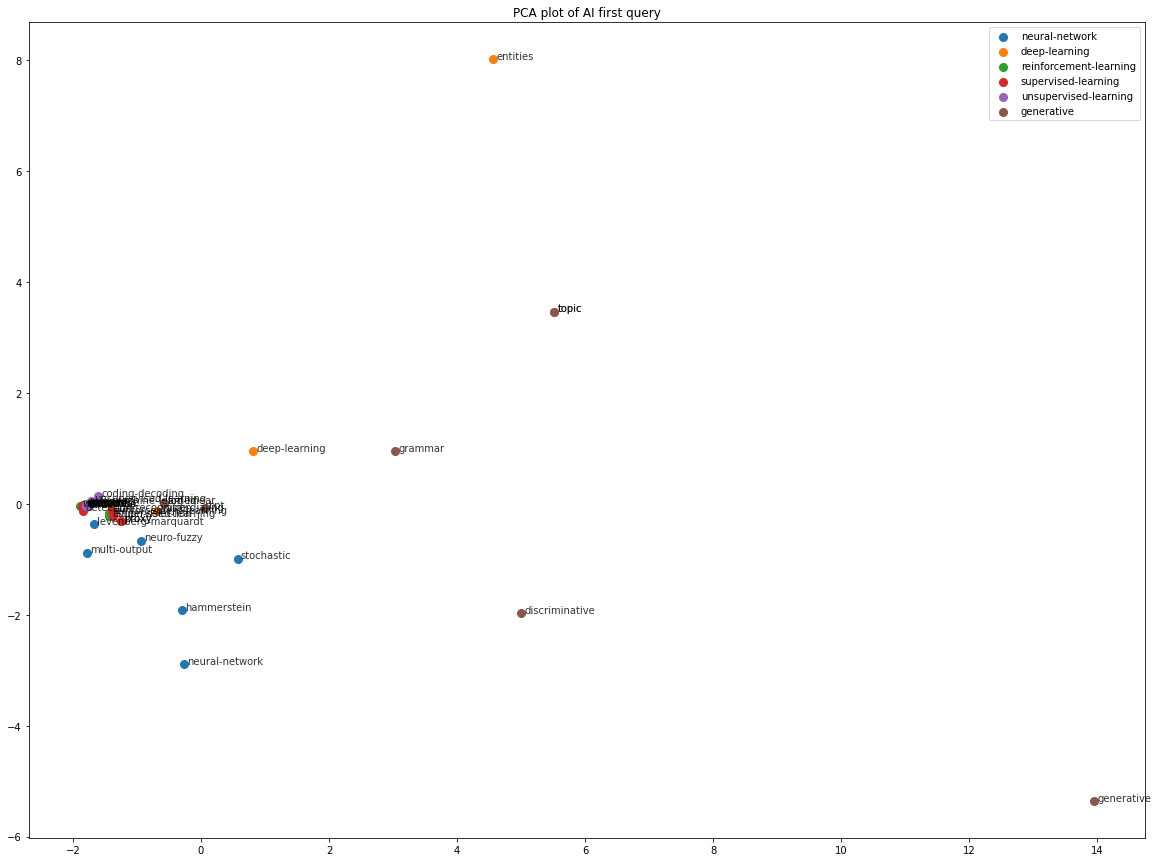

In [36]:
#  Word2Vec model
model = Word2Vec.load("word2vec_model.model")

#listing the query
words_to_visualize = ["neural-network", "deep-learning", "reinforcement-learning", "supervised-learning", "unsupervised-learning", "generative"]

# dictionary to store most similar words for each word
most_similar_words = {word: model.wv.most_similar(word, topn=5) for word in words_to_visualize}

# lst that includes the words and their most similar words
data_points = []

for word in words_to_visualize:
    data_points.append((word, word, 0.0, True))  # Add the central word with True for highlighting
    for similar_word, similarity in most_similar_words[word]:
        data_points.append((similar_word, word, similarity, False))  # Add the similar words with False

# Convert the data to a DataFrame
data = pd.DataFrame(data_points, columns=['Word', 'Central_Word', 'Similarity', 'Highlight'])

# PCA for dimension reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data['Word'].apply(lambda x: model.wv[x]).values.tolist())

# plotting
plt.rcParams["figure.figsize"] = (20, 15)

for central_word in words_to_visualize:
    central_word_data = data[data['Central_Word'] == central_word]
    scatter = plt.scatter(x=pca_result[central_word_data.index, 0], y=pca_result[central_word_data.index, 1], s=64, label=central_word, marker='o')

for i, row in data.iterrows():
    if row['Highlight']:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8)
    else:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8, color='black')

plt.title(f"PCA plot of AI first query")
plt.legend()
plt.savefig("word2vec_query1.png")
plt.show()

INFO - 15:58:20: loading Word2Vec object from word2vec_model2.model
INFO - 15:58:20: loading wv recursively from word2vec_model2.model.wv.* with mmap=None
INFO - 15:58:20: setting ignored attribute cum_table to None
INFO - 15:58:20: Word2Vec lifecycle event {'fname': 'word2vec_model2.model', 'datetime': '2023-11-06T15:58:20.851587', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


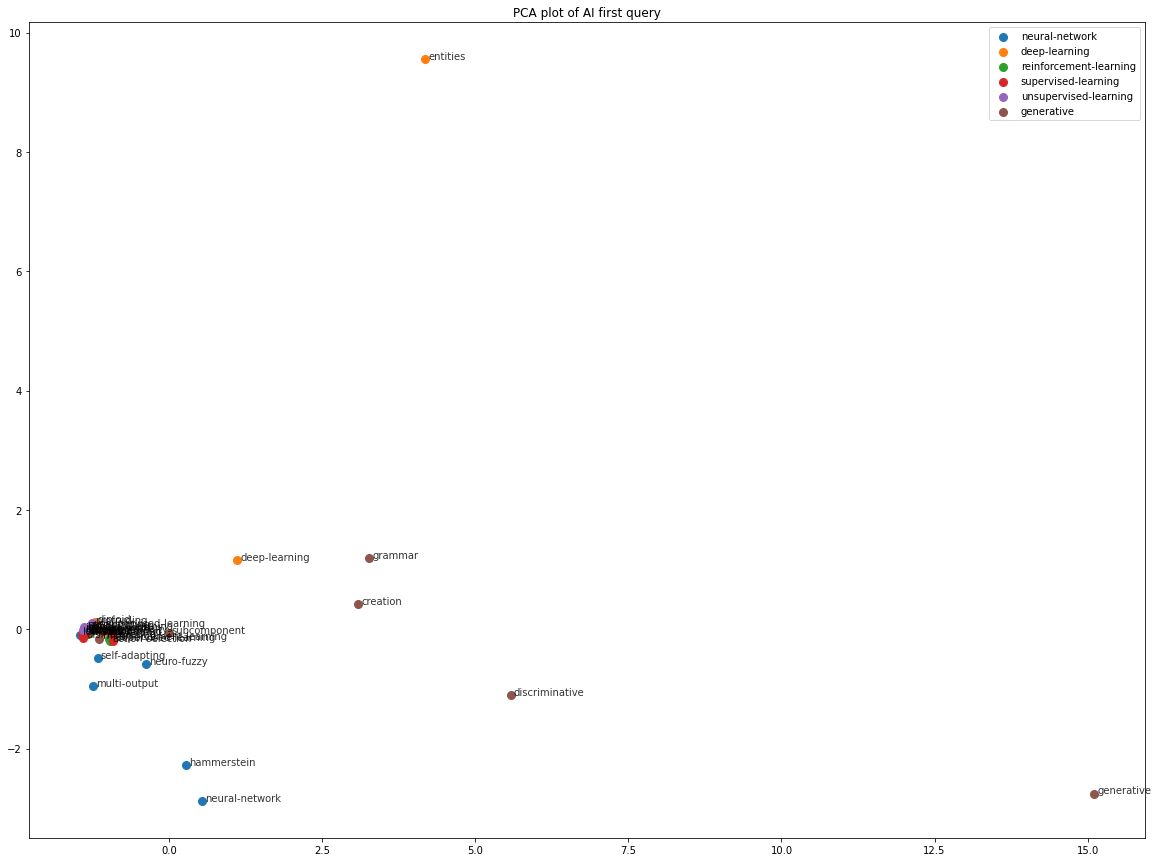

In [37]:
#  Word2Vec model
model2 = Word2Vec.load("word2vec_model2.model")

#listing the query
words_to_visualize = ["neural-network", "deep-learning", "reinforcement-learning", "supervised-learning", "unsupervised-learning", "generative"]

# dictionary to store most similar words for each word
most_similar_words = {word: model2.wv.most_similar(word, topn=5) for word in words_to_visualize}

# lst that includes the words and their most similar words
data_points = []

for word in words_to_visualize:
    data_points.append((word, word, 0.0, True))  # Add the central word with True for highlighting
    for similar_word, similarity in most_similar_words[word]:
        data_points.append((similar_word, word, similarity, False))  # Add the similar words with False

# Convert the data to a DataFrame
data = pd.DataFrame(data_points, columns=['Word', 'Central_Word', 'Similarity', 'Highlight'])

# PCA for dimension reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data['Word'].apply(lambda x: model.wv[x]).values.tolist())

# plotting
plt.rcParams["figure.figsize"] = (20, 15)

for central_word in words_to_visualize:
    central_word_data = data[data['Central_Word'] == central_word]
    scatter = plt.scatter(x=pca_result[central_word_data.index, 0], y=pca_result[central_word_data.index, 1], s=64, label=central_word, marker='o')

for i, row in data.iterrows():
    if row['Highlight']:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8)
    else:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8, color='black')

plt.title(f"PCA plot of AI first query")
plt.legend()
plt.savefig("word2vec_query2.png")
plt.show()

In [5]:
# extract embeddings for the whole dataset
word_embeddings = model.wv

In [6]:
import numpy as np

# Calculate mean and standard deviation for each dimension
mean_embeddings = np.mean(word_embeddings.vectors, axis=0)
std_embeddings = np.std(word_embeddings.vectors, axis=0)


In [25]:
num_dimensions = model.vector_size
num_dimensions

100

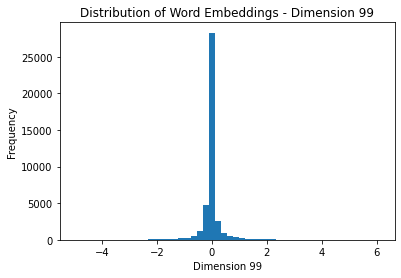

In [28]:
import matplotlib.pyplot as plt

# Visualize the distribution of a specific dimension (e.g., dimension 0)
dimension_to_visualize = 99
plt.hist(word_embeddings.vectors[:, dimension_to_visualize], bins=50)
plt.xlabel(f'Dimension {dimension_to_visualize}')
plt.ylabel('Frequency')
plt.title(f'Distribution of Word Embeddings - Dimension {dimension_to_visualize}')
plt.show()


In [31]:
# Find words with embeddings in the specific dimension (e.g., dimension 0)
words_in_dimension = []
for word in model.wv.index_to_key:
    if word in model.wv and model.wv[word][99] != 0:
        words_in_dimension.append((word, model.wv[word][99]))

In [38]:
len(words_in_dimension)

40929

In [35]:
from sklearn.decomposition import PCA

# Select the number of components (2 for 2D)
num_components = 2

# Initialize and fit the PCA model
pca = PCA(n_components=num_components)
reduced_embeddings = pca.fit_transform(word_embeddings.vectors)


In [36]:
import pandas as pd

# Create a DataFrame for the reduced embeddings
df = pd.DataFrame(reduced_embeddings, columns=['Dimension 1', 'Dimension 2'])

# Compute summary statistics
summary_stats = df.describe()
print(summary_stats)


        Dimension 1   Dimension 2
count  4.092900e+04  4.092900e+04
mean   2.147392e-07  1.083016e-07
std    8.418354e-01  8.129910e-01
min   -8.931238e+00 -9.171954e+00
25%   -1.104769e-01 -6.982684e-02
50%    6.504354e-02  1.158283e-02
75%    1.549695e-01  9.120908e-02
max    9.561618e+00  9.226503e+00


In [37]:
num_words = len(reduced_embeddings)
print(f"Number of words in the 2D space: {num_words}")

Number of words in the 2D space: 40929


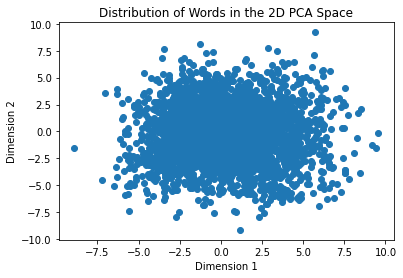

In [39]:
import matplotlib.pyplot as plt

# Create a scatter plot of the reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Distribution of Words in the 2D PCA Space')
plt.show()


In [40]:
from collections import Counter

# Count word frequencies
word_counts = Counter([word for word, _ in words_in_dimension])

# Display the most common words and their counts
most_common_words = word_counts.most_common(10)
for word, count in most_common_words:
    print(f"Word: {word}, Count: {count}")


Word: ,, Count: 1
Word: ., Count: 1
Word: network, Count: 1
Word: neural, Count: 1
Word: method, Count: 1
Word: ), Count: 1
Word: (, Count: 1
Word: ;, Count: 1
Word: data, Count: 1
Word: system, Count: 1


In [41]:
from scipy.stats import zscore

# Compute Z-scores for the 2D embeddings
z_scores = zscore(reduced_embeddings)

# Define a threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Find the indices of potential outliers
outlier_indices = (abs(z_scores) > threshold).any(axis=1)
outlier_words = [word for i, word in enumerate(words_in_dimension) if outlier_indices[i]]


In [43]:
len(outlier_words)

1928

In [45]:
(len(outlier_words)/num_words)*100

4.71059639864155

In [46]:
outlier_words

[('network', -0.96995735),
 ('neural', -0.08210507),
 ('method', 0.7280584),
 (')', -3.1745563),
 ('(', -3.8452995),
 (';', -2.140911),
 ('data', -1.5823214),
 ('system', 1.1959679),
 ('input', 0.03156395),
 ('output', -1.4672002),
 ('based', -1.0570192),
 ('model', -1.2767477),
 ('learning', 1.2389622),
 ('image', -1.2919211),
 ('using', -1.389684),
 ('control', 3.163298),
 ('signal', 1.4211513),
 ('value', -1.5683367),
 ('invention', -0.3051991),
 ('training', -2.8349602),
 ('one', -1.2916299),
 ('information', 2.5216177),
 ('processing', 0.97407717),
 ('layer', -0.38642633),
 ('time', 1.0402303),
 ('set', -2.942992),
 ('used', -1.1838044),
 ('according', -1.4383894),
 ('first', -1.1169646),
 ('recognition', 2.3730853),
 ('unit', -1.3759382),
 ('plurality', -0.63636094),
 ('function', -0.41387266),
 ('parameters', -3.6976972),
 ('values', -3.0768726),
 ('part', -2.1343427),
 ('feature', 0.5411723),
 ('pattern', -1.0455949),
 ('means', -2.150113),
 ('signals', -0.182711),
 ('algorithm